### Instructions
The lecture applies an svc model (specifically a regression model) to the [epicurious dataset on Kaggle](https://www.kaggle.com/hugodarwood/epirecipes).  The information in the dataset includes a list keywords and ingredients as well as the title of the recipe and a rating.  The goal was to predict the rating.  By removing columns with null values, they got a score of -0.004.  **I am tasked to 1) use a support vector classification model and 2) cut down the feature set to about 30 features.**  

### 1 - Loading the Data
The dataset has ~15.8k rows and a whopping 680 features, all of which are numerical values aside from the title.  

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.svm import SVR, SVC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import preprocessing

import warnings
warnings.filterwarnings("ignore")

C:\Users\Crystal\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


In [2]:
df = pd.read_csv('epi_r.csv')

In [3]:
df.head()

,title,rating,calories,protein,fat,sodium,#cakeweek,#wasteless,22-minute meals,3-ingredient recipes,...,yellow squash,yogurt,yonkers,yuca,zucchini,cookbooks,leftovers,snack,snack week,turkey
0,"Lentil, Apple, and Turkey Wrap",2.500,426.0,30.0,7.0,559.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,Boudin Blanc Terrine with Red Onion Confit,4.375,403.0,18.0,23.0,1439.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Potato and Fennel Soup Hodge,3.750,165.0,6.0,7.0,165.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Mahi-Mahi in Tomato Olive Sauce,5.000,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Spinach Noodle Casserole,3.125,547.0,20.0,32.0,452.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
df.shape

(20052, 680)

The features concerning keywords and ingredients only have values of 0 or 1 to indicate if its in the recipe or not.  Including those in the describe function may not be useful.  The ratings however, show that the mean is 3.76, which is very close to the 25th percentile of 3.75, indicating that there might be a lot of ratings that are 1 or 0. 

In [5]:
df['rating'].describe()

count    20052.000000
mean         3.714467
std          1.340829
min          0.000000
25%          3.750000
50%          4.375000
75%          4.375000
max          5.000000
Name: rating, dtype: float64

#### 1.1 - Missing values
First thing first, what missing values do we have?  Calories, protein, fat, and sodium all have missing values.  As the lecture calls it, these are the nutritional information.  I've opted to just remove the rows that have missing values since I want to know if nutrional value plays a role in ratings.  

In [6]:
for col in df.columns:
    if df[col].isnull().sum() > 0:
        print(col, df[col].isnull().sum())

calories 4117
protein 4162
fat 4183
sodium 4119


In [7]:
df.dropna(axis = 0, inplace = True)

#### 1.2 - A Look at Ratings
A histogram of the ratings show a bimodal model, with a peak at around 4 and another peak at 0.  Another thing to notice is that there are only 8 unique values for the ratings, which surprises me as I'd expect a more continuous range for ratings.  Perhaps this is why the lecture's regression model did so poorly?

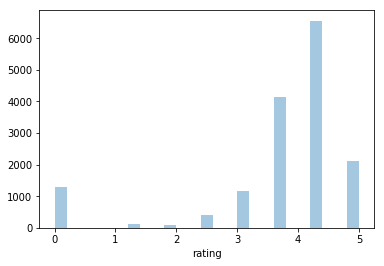

In [8]:
sns.distplot(df['rating'], bins= 25,kde = False)

In [9]:
df['rating'].unique()

array([ 2.5  ,  4.375,  3.75 ,  3.125,  1.875,  5.   ,  0.   ,  1.25 ])

### 2 - Finding correlated features
One part of this assignment is to reduce the number of features down to about 30.  I'm taking a page from the OLS lectures and finding features that are most correlated with ratings.  With a threshold of 0.05, I get 37 features.  Lets see how this does!

In [10]:
cols_important = [col for col in df.columns[2:] if df[[col, 'rating']].corr().abs()['rating'][0] > 0.05]

In [11]:
len(cols_important)

37

### 3 - SVC
SVC is notoriously slow, so I'm sampling 65% of the original dataset to reduce computational time.  For the classification model, the target variable (rating) will throw up an error if I try to run it as is.  To overcome this problem, the rating must be label encoded.  

In [12]:
df2 = df.sample(frac = 0.65)

In [13]:
X = df2[cols_important]
Y = df2['rating']

In [14]:
label_enc = preprocessing.LabelEncoder()
Y = label_enc.fit_transform(Y)
# Y = Y.astype('category')

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [16]:
svc = SVC()
svc.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

Cross validation scores have a mean of ~0.43.  I test if 3, 5, or 10 foldsis optimal, and it turns out that 5 folds is the best, but the difference in score for each number of folds is extremely small.  Applying a 5 fold cross validation to the test set also results in a score of 0.428, but with a slightly larger variance of 0.017.

In [18]:
for folds in [3, 5, 10]:
    print(cross_val_score(svc, X_train, y_train, cv = folds).mean())

0.427567676055
0.428050817227
0.427808683967


In [23]:
cv_score = cross_val_score(svc, X_train, y_train, cv = 5)

In [24]:
print('CV score of training set with 10 folds has mean of {:.3f} and range of {:.3f}.'.format(cv_score.mean(), cv_score.max()-cv_score.min()))

CV score of training set with 10 folds has mean of 0.428 and range of 0.013.


In [25]:
cv_test = cross_val_score(svc, X_test, y_test, cv = 5)

In [26]:
print('CV score of test set with 10 folds has mean of {:.3f} and range of {:.3f}.'.format(cv_test.mean(), cv_test.max()-cv_test.min()))

CV score of test set with 10 folds has mean of 0.428 and range of 0.017.
